# RNN

В данном ноутбуке представлены эксперименты с обучением RNN моделей LSTM и GRU. Обе модели были обучены сначала с предобученным word2vec, а затем с составлением собственных эмбеддингов из предобработанных текстов, которые были получены в чекпоинте 5

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import nltk
import gensim.downloader
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from tqdm import tqdm
from IPython.display import clear_output

pandarallel.initialize(progress_bar=True)
nltk.download('punkt')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /Users/lev_k/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

Метрика для оценки качества модели

In [3]:
def f1_metric(preds, targets):
    preds = (preds > 0).int().cpu().numpy()
    targets = targets.int().cpu().numpy()
    return f1_score(targets, preds, average="binary", zero_division=0)

Функции для обучения/тестирования модели и отрисовки графика обучения

In [4]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train F1 values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation F1 values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("F1")
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    scheduler=None,
    verbose=True,
    checkpoint_dir='checkpoints',
    model_dir='GRU',
    checkpoint_prefix='toxic_gru',
    save_every=2,
    save_best_only=False,
):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(f'{checkpoint_dir}/{model_dir}'):
        os.makedirs(f'{checkpoint_dir}/{model_dir}')

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    best_val_metric = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, batch in enumerate(pbar, 1):
            if len(batch) == 3:
                X_batch, y_batch, lengths = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).view(-1)
                lengths = lengths.to(device)
                predictions = model(X_batch, lengths)
            else:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device, dtype=torch.float32)
                y_batch = y_batch.to(device).view(-1)
                predictions = model(X_batch)

            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "F1": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, batch in enumerate(pbar, 1):
            if len(batch) == 3:
                X_batch, y_batch, lengths = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).view(-1)
                lengths = lengths.to(device)
                
                with torch.no_grad():
                    predictions = model(X_batch, lengths)
                    loss = criterion(predictions, y_batch)
            else:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device, dtype=torch.float32)
                y_batch = y_batch.to(device).view(-1)
                
                with torch.no_grad():
                    predictions = model(X_batch)
                    loss = criterion(predictions, y_batch)

            metric_value = metric(predictions, y_batch)
            if type(metric_value) == torch.Tensor:
                metric_value = metric_value.item()
            running_loss += loss.item() * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "F1": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_losses[-1])
            else:
                scheduler.step()
        
        is_best = val_metrics[-1] > best_val_metric
        best_val_metric = max(best_val_metric, val_metrics[-1])
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'best_val_metric': best_val_metric,
        }

        if epoch % save_every == 0 and not save_best_only:
            torch.save(checkpoint, f'{checkpoint_dir}/{model_dir}/{checkpoint_prefix}_checkpoint_epoch_{epoch}.pth')
        
        if is_best:
            torch.save(checkpoint, f'{checkpoint_dir}/{model_dir}/{checkpoint_prefix}_best.pth')
            torch.save(model, f'{checkpoint_prefix}_best_model.pt')
            if verbose:
                print(f"Сохранена лучшая модель с валидационным F1: {val_metrics[-1]:.4f}")

        if verbose:
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation F1: {val_metrics[-1]:.3f}")
        print(f"Best Validation F1: {best_val_metric:.3f}")
    
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'best_val_metric': best_val_metric,
    }
    torch.save(final_checkpoint, f'{checkpoint_dir}/{checkpoint_prefix}_checkpoint_final.pth')
    torch.save(model, f'{checkpoint_prefix}_final_model.pt')

    return train_metrics[-1], val_metrics[-1]

def test(model, loader):
    model.eval()
    
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc=f"Testing")
    
    for i, batch in enumerate(pbar, 1):
        if len(batch) == 3:
            X_batch, y_batch, lengths = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1)
            lengths = lengths.to(device)
            
            with torch.no_grad():
                predictions = model(X_batch, lengths)
        else:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device).view(-1)
            
            with torch.no_grad():
                predictions = model(X_batch)

        all_preds.append(predictions)
        all_targets.append(y_batch)

    return f1_metric(torch.cat(all_preds), torch.cat(all_targets))

## Предобученный Word2Vec

In [5]:
class ToxicDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = np.array(texts.tolist(), dtype=np.float32) if isinstance(texts, pd.Series) else texts
        self.labels = labels.values.astype(np.float32) if isinstance(labels, pd.Series) else labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.texts[idx]),  # [input_dim]
            torch.FloatTensor([self.labels[idx]])  # [1]
        )

In [6]:
# Векторизация текста
def text_to_vector_w2v(text, embedding_model, max_len=1000):
    """Преобразование текста в усредненный вектор"""
    words = word_tokenize(text.lower())
    vectors = []
    for word in words:
        try:
            vectors.append(embedding_model[word].astype(np.float32))
        except KeyError:
            continue
    if len(vectors) < max_len:
        vectors += [np.zeros(embedding_model.vector_size, dtype=np.float32)] * (max_len - len(vectors))
    else:
        vectors = vectors[:max_len]
    return np.mean(vectors, axis=0).astype(np.float32)

Для обучения модели на готовых эмбеддингах возьмем `word2vec-google-news-300`, который использовался в прошлом чекпоинте

In [7]:
gn300_path = gensim.downloader.load('word2vec-google-news-300', return_path=True)

In [8]:
word2vec = KeyedVectors.load_word2vec_format(gn300_path, binary=True)

In [9]:
df = pd.read_csv("../../modified_train.csv", usecols=["comment_text", "toxicity_b"])

In [10]:
df["vectorized"] = df["comment_text"].parallel_apply(lambda x: text_to_vector_w2v(x, word2vec))

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df["vectorized"], df["toxicity_b"], test_size=0.2, random_state=42)

X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [12]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### LSTM

In [14]:
class ToxicCommentLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        dropout=0.5,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Добавляем размерность последовательности
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        output, (hidden, cell) = self.lstm(x)
        hidden = self.dropout(hidden[-1])  # [batch_size, hidden_dim]
        return self.fc(hidden).squeeze()  # [batch_size]

In [15]:
model = ToxicCommentLSTM(
    input_dim=word2vec.vector_size,
    hidden_dim=512,
    output_dim=1,
).to(device, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.6,
    patience=2
)

pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

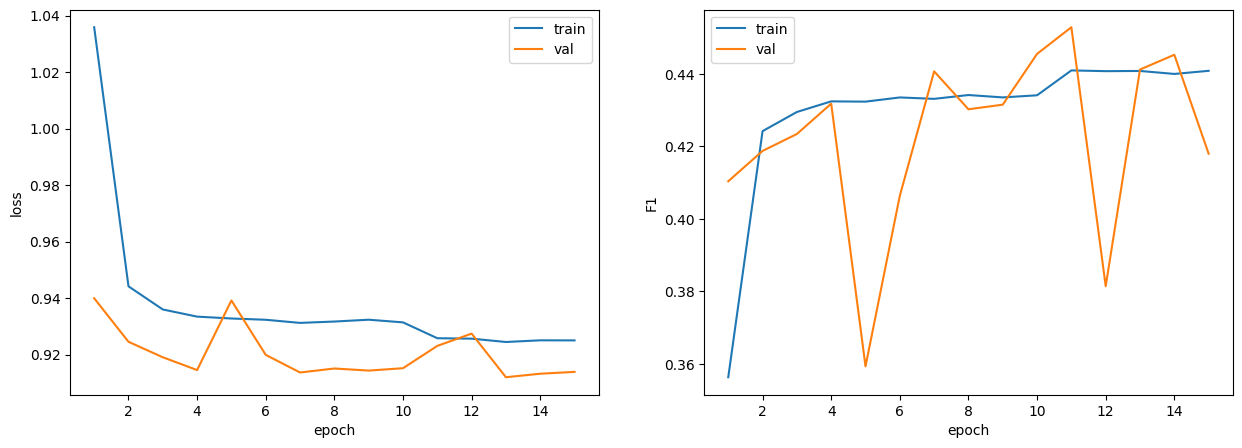

Validation F1: 0.418
Best Validation F1: 0.453


In [16]:
train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    scheduler=scheduler,
    verbose=True,
    model_dir='LSTM',
    checkpoint_prefix='toxic_lstm_w2v'
)

Проверка финальной модели после 15 эпох обучения

In [17]:
round(test(model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [00:13<00:00, 821.03it/s]


0.442

Проверка лучшей модели, полученной в ходе обучения

In [18]:
best_model = torch.load("toxic_lstm_w2v_best_model.pt", weights_only=False)

In [19]:
round(test(best_model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [00:13<00:00, 821.46it/s]


0.488

### GRU

In [ ]:
class ToxicCommentGRU(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        dropout=0.5,
    ):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Добавляем размерность последовательности
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        output, hidden = self.gru(x)
        hidden = self.dropout(hidden[-1])  # [batch_size, hidden_dim]
        return self.fc(hidden).squeeze()  # [batch_size]

In [14]:
model = ToxicCommentGRU(
    input_dim=word2vec.vector_size,
    hidden_dim=512,
    output_dim=1,
).to(device, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.6,
    patience=2
)

pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

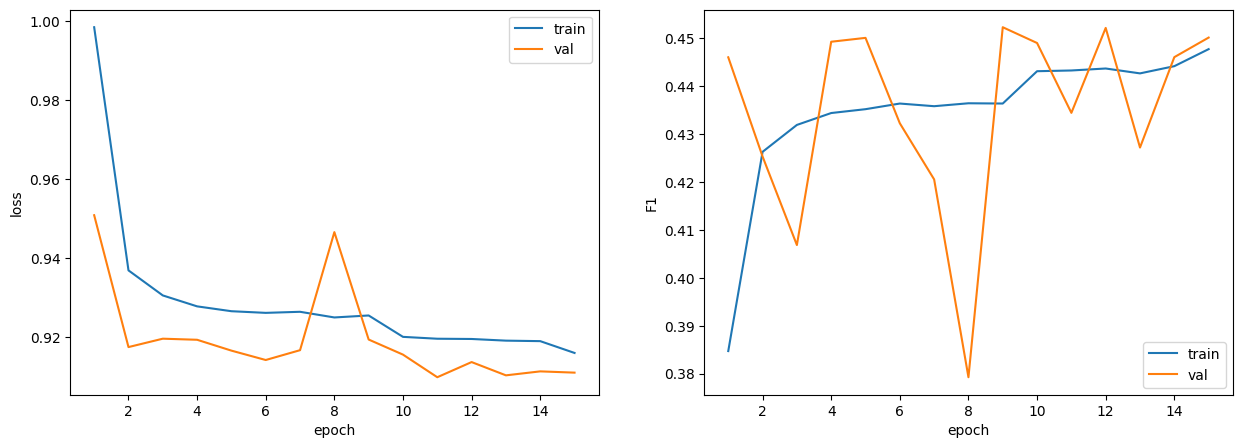

Validation F1: 0.450
Best Validation F1: 0.452


In [15]:
train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    scheduler=scheduler,
    verbose=True,
    checkpoint_prefix="toxic_gru_w2v"
)

Проверка финальной модели после 15 эпох обучения

In [18]:
round(test(model, test_loader), 3)

Testing:   0%|          | 0/11248 [00:00<?, ?it/s]

Testing: 100%|██████████| 11248/11248 [00:19<00:00, 563.21it/s]


0.482

Проверка лучшей модели, полученной в ходе обучения

In [20]:
best_model = torch.load("toxic_gru_w2v_best_model.pt", weights_only=False)

In [21]:
round(test(best_model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [00:19<00:00, 570.71it/s]


0.487

Обе модели показали примерно одинаковый результат на тестовых данных, и он хуже, чем лучший результат, полученный на этапе нелинейных ML-моделей (0.66 у XGBoost)

## Собственные эмбеддинги с кастомной предобработкой текста

Теперь попробуем обучить эти модели с собственными эмбеддингами из предобработанного текста

In [ ]:
class Vocabulary:
    def __init__(self, counter, specials=['<unk>', '<pad>'], min_freq=1):
        self.specials = specials
        self.min_freq = min_freq
        
        # Добавление специальных токенов
        self.idx2token = specials.copy()
        self.token2idx = {token: idx for idx, token in enumerate(specials)}
        
        # Фильтрация токенов по частоте и добавление в словарь
        for token, count in counter.items():
            if count >= min_freq and token not in self.token2idx:
                self.token2idx[token] = len(self.idx2token)
                self.idx2token.append(token)
                
        # Установка индекса по умолчанию для неизвестных слов
        self.default_idx = self.token2idx['<unk>']
    
    def __getitem__(self, token):
        return self.token2idx.get(token, self.default_idx)
    
    def __len__(self):
        return len(self.idx2token)
    
    def get_itos(self):
        return self.idx2token
    
    def get_stoi(self):
        return self.token2idx

In [6]:
preprocessed_df = pd.read_csv("../../preprocessed_train.csv", index_col=0)

In [7]:
preprocessed_df['processed_ct'] = preprocessed_df['processed_ct'].fillna('')

In [ ]:
# Создание словаря токенов
counter = Counter()
for tokens in preprocessed_df['processed_ct']:
    if tokens.strip():
        counter.update(tokens.split())

vocab = Vocabulary(counter, specials=['<unk>', '<pad>'], min_freq=10)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 40734


In [9]:
class ToxicDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels.values.astype(np.float32) if isinstance(labels, pd.Series) else labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.sequences[idx]),
            torch.FloatTensor([self.labels[idx]])
        )

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)
    lengths = torch.tensor([max(1, len(seq)) for seq in sequences])
    padded_sequences = pad_sequence(
        sequences, 
        batch_first=True, 
        padding_value=vocab['<pad>']
    )
    return padded_sequences, torch.stack(labels), lengths

# Преобразование текстов в последовательности индексов
def text_to_sequence(text):
    return [vocab[token] for token in text.split()]

In [10]:
preprocessed_df['sequence'] = preprocessed_df['processed_ct'].parallel_apply(text_to_sequence)

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(preprocessed_df['sequence'], preprocessed_df['toxicity_b'], test_size=0.2, random_state=42)

X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [12]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

### LSTM

In [ ]:
class ToxicCommentLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        input_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, 
            input_dim, 
            padding_idx=vocab['<pad>']
        )
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=False,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(
            embedded,
            text_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze(1)

In [18]:
model = ToxicCommentLSTM(
    vocab_size=len(vocab),
    input_dim=256,
    hidden_dim=512,
    output_dim=1,
).to(device, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.6,
    patience=2
)

pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

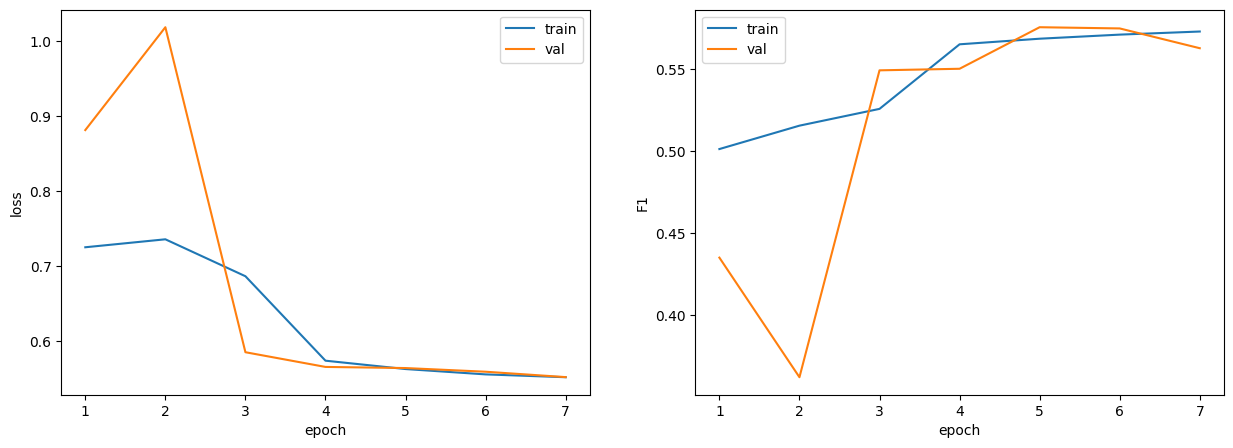

Validation F1: 0.563
Best Validation F1: 0.576


In [19]:
train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=7,
    scheduler=scheduler,
    verbose=True,
    model_dir='LSTM',
    checkpoint_prefix='toxic_lstm_emdedding'
)

Проверка финальной модели после 7 эпох обучения

In [20]:
round(test(model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [08:06<00:00, 23.10it/s]


0.592

Проверка лучшей модели, полученной в ходе обучения

In [ ]:
best_model = torch.load("toxic_lstm_emdedding_best_model.pt", weights_only=False)

In [ ]:
round(test(best_model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [08:49<00:00, 21.24it/s]


0.613

### GRU

In [ ]:
class ToxicCommentGRU(nn.Module):
    def __init__(
        self,
        vocab_size,
        input_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, 
            input_dim, 
            padding_idx=vocab['<pad>']
        )
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=False,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(
            embedded,
            text_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        packed_output, hidden = self.gru(packed_embedded)
        hidden = self.dropout(hidden.squeeze(0))
        return self.fc(hidden).squeeze(1)

In [14]:
model = ToxicCommentGRU(
    vocab_size=len(vocab),
    input_dim=256,
    hidden_dim=512,
    output_dim=1,
).to(device, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.6,
    patience=2
)

pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

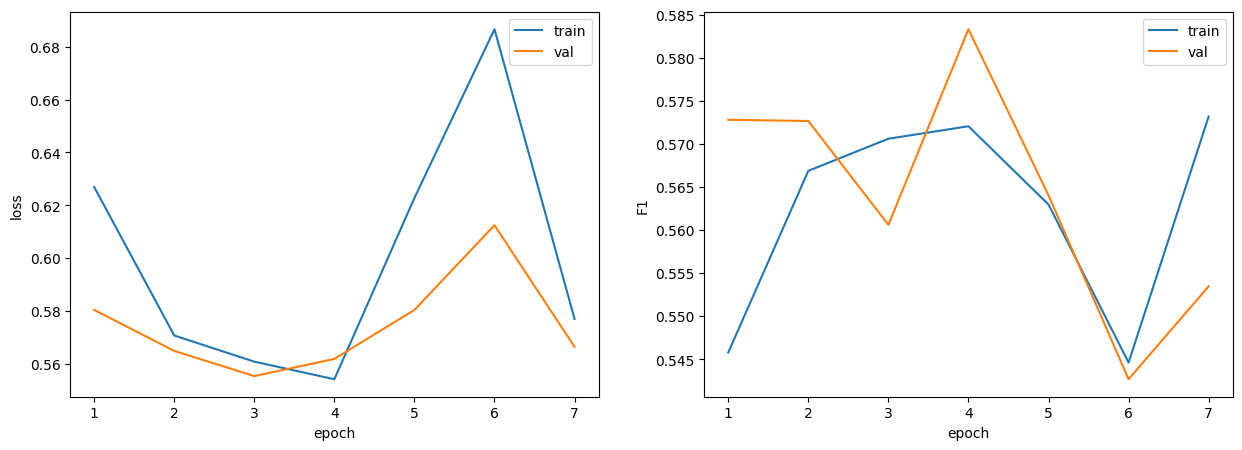

Validation F1: 0.553
Best Validation F1: 0.583


In [15]:
train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=7,
    scheduler=scheduler,
    verbose=True,
    checkpoint_prefix='toxic_gru_emdedding'
)

Проверка финальной модели после 7 эпох обучения

In [16]:
round(test(model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [08:38<00:00, 21.69it/s]


0.581

Проверка лучшей модели, полученной в ходе обучения

In [17]:
best_model = torch.load("toxic_gru_emdedding_best_model.pt", weights_only=False)

In [18]:
round(test(best_model, test_loader), 3)

Testing: 100%|██████████| 11248/11248 [08:49<00:00, 21.24it/s]


0.613

Модели, обученные на собственных эмбеддингах, снова показали примерно одинаковый результат на тестовых данных, он приблизился к результату лучшей нелинейной модели, но все еще немного хуже